# Spatial Data Analysis - mini Project
# Grocery Shops within London

## try to analyse the spatial distribution of the shops in London

In [64]:
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")

from shapely.geometry import Point

import pysal as ps

import warnings
warnings.simplefilter('ignore')

## Data Preprocessing

In [65]:
from OSMPythonTools.nominatim import Nominatim
from OSMPythonTools.overpass import Overpass
nominatim = Nominatim()
# get area id
areaId = nominatim.query('London, UK').areaId()
areaId

3600065606

In [66]:
api = Overpass()
# request supermarkets with area id
r1 = api.query("""
area(3600065606);
node["shop"="supermarket"](area);
out;
""")
# print (r.nodes()[0].geometry)

In [67]:
coords  = []
coords += [[node.id(), node.tag('name'), node.tag('shop'), node.tag('brand'), float(node.lon()), float(node.lat())]
           for node in r1.nodes()]

In [68]:

# request convenience shops with area id
r2 = api.query("""
area(3600065606);
node["shop"="convenience"](area);
out;
""")

In [69]:
coords += [[node.id(), node.tag('name'), node.tag('shop'), node.tag('brand'), float(node.lon()), float(node.lat())]
           for node in r2.nodes()]

In [70]:
print (r1.nodes()[0])

In [71]:
shop_df = pd.DataFrame(coords, columns = ['id', 'name', 'type', 'brand', 'longitude', 'latitude'])
shop_df

,id,name,type,brand,longitude,latitude
0,25544124,Tesco Metro,supermarket,Tesco Metro,-0.125165,51.511122
1,25744394,Tesco Express,supermarket,Tesco Express,-0.149359,51.562078
2,25813308,tesco express,supermarket,None,-0.133341,51.545341
3,26618618,Marks and Spencer,supermarket,None,-0.142041,51.537810
4,26817795,Tesco Express,supermarket,None,-0.158722,51.522805
...,...,...,...,...,...,...
2819,7401591150,Sainsbury's Local,convenience,Sainsbury's Local,-0.205008,51.497141
2820,7401798511,Sainsbury's Local,convenience,Sainsbury's Local,-0.129237,51.432494
2821,7419375764,Sainsbury's Local,convenience,Sainsbury's Local,-0.210045,51.402717
2822,7433268116,None,convenience,None,0.019572,51.550955


In [72]:
shop_df.to_csv('data/shops_LDN.csv')

In [73]:
len(shop_df[shop_df.type=='supermarket'])

647

In [ ]:
import os
import requests
import zipfile

src = 'https://github.com/cusp-london/Spatial-Data-Analysis/blob/master/LSOA_IMD.zip?raw=true'
dst = 'data/LSOA_IMD.zip'
zpd = 'data/'
if not os.path.exists(dst):
    if not os.path.exists(os.path.dirname(dst)):
        os.makedirs(os.path.dirname(dst))
    
    r = requests.get(src, stream=True)
    
    with open(dst, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=128):
            fd.write(chunk)

if not os.path.exists(zpd):
    os.makedirs(os.path.dirname(zpd))
    
zp = zipfile.ZipFile(dst, 'r')
zp.extractall(zpd)
zp.close()   

In [74]:
geometry = [Point(xy) for xy in zip(shop_df.longitude, shop_df.latitude)]

In [75]:
# GeoDataFrame
shop_gdf = gpd.GeoDataFrame(shop_df, geometry =geometry, crs={'init' :'epsg:4326'})
shop_gdf

,id,name,type,brand,longitude,latitude,geometry
0,25544124,Tesco Metro,supermarket,Tesco Metro,-0.125165,51.511122,POINT (-0.12516 51.51112)
1,25744394,Tesco Express,supermarket,Tesco Express,-0.149359,51.562078,POINT (-0.14936 51.56208)
2,25813308,tesco express,supermarket,None,-0.133341,51.545341,POINT (-0.13334 51.54534)
3,26618618,Marks and Spencer,supermarket,None,-0.142041,51.537810,POINT (-0.14204 51.53781)
4,26817795,Tesco Express,supermarket,None,-0.158722,51.522805,POINT (-0.15872 51.52281)
...,...,...,...,...,...,...,...
2819,7401591150,Sainsbury's Local,convenience,Sainsbury's Local,-0.205008,51.497141,POINT (-0.20501 51.49714)
2820,7401798511,Sainsbury's Local,convenience,Sainsbury's Local,-0.129237,51.432494,POINT (-0.12924 51.43249)
2821,7419375764,Sainsbury's Local,convenience,Sainsbury's Local,-0.210045,51.402717,POINT (-0.21005 51.40272)
2822,7433268116,None,convenience,None,0.019572,51.550955,POINT (0.01957 51.55095)


In [76]:
# We call folium to realize interactive heatmap of London pubs
import folium
from folium import plugins
from folium.plugins import HeatMap, MarkerCluster, FastMarkerCluster

heat_df = shop_gdf[['latitude', 'longitude']]

# List comprehension to make out list of lists
heat_data = [[row['latitude'],row['longitude']] for index, row in heat_df.iterrows()]

heatmap_map = folium.Map([51.50632, -0.1271448], zoom_start=12)

# Plot it on the map
hm=plugins.HeatMap(heat_data)
heatmap_map.add_child(hm)
# get the map shown below 
# if it is blank for browser reason, please save it as html file
heatmap_map

In [77]:
lsoa = gpd.read_file('data/LSOA_IMD/LSOA_IMD2019.shp')

In [78]:
shop_gdf.crs

{'init': 'epsg:4326'}

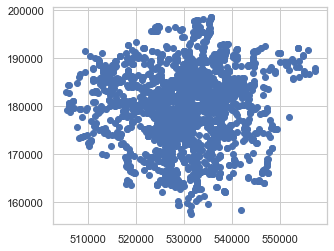

In [79]:
shop_gdf = shop_gdf.to_crs(lsoa.crs)
shop_gdf.plot()

In [80]:
shop_gdf.to_file('data/shops_supermarket&convenience_LDN.shp')

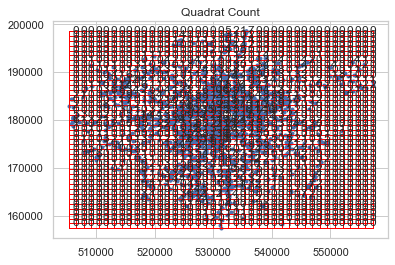

In [86]:
import pointpats 
from pointpats import PointPattern
import pointpats.quadrat_statistics as qs
f = ps.lib.io.open('data/shops_supermarket&convenience_LDN.shp')
# get the points
pp_shops = PointPattern(np.asarray([pnt for pnt in f]))
f.close() # why we need to call f.close()?
q_r_shops = qs.QStatistic(pp_shops,shape= "rectangle",nx = 40, ny = 40)
q_r_shops.plot() # plot out the quadrat count figure with 20*20 windows
# plt.savefig('output/quadrat.png')
# plt.close()

In [87]:
print('Chi-squared test statistic for the observed point pattern is: '+ str(q_r_shops.chi2)) 
print('Degree of freedom is: '+str(q_r_shops.df)) 
print('P-valus for Chi-squared test statistic is: '+str.format('{0:.6f}', q_r_shops.chi2_pvalue)) 

Chi-squared test statistic for the observed point pattern is: 11492.147308781869
Degree of freedom is: 1599
P-valus for Chi-squared test statistic is: 0.000000


In [88]:
# pointsInPolys = pointsInPolys.drop('index_right', axis=1)
lsoa['ShopDens'] = lsoa.apply(lambda row:1*100000/row['st_areasha'], axis=1)

In [89]:
pointsInPolys = gpd.sjoin(shop_gdf, lsoa[['ShopDens', 'lsoa11cd', 'st_areasha', 'geometry']],  how='right', op='within')
pointsInPolys

,index_left,id,name,type,brand,longitude,latitude,ShopDens,lsoa11cd,st_areasha,geometry
index_right,,,,,,,,,,,
4613,0.0,2.554412e+07,Tesco Metro,supermarket,Tesco Metro,-0.125165,51.511122,0.312200,E01004734,3.203077e+05,"POLYGON ((529794.943 180929.364, 529797.104 18..."
4613,379.0,3.841675e+09,SeeWoo,supermarket,None,-0.130398,51.511629,0.312200,E01004734,3.203077e+05,"POLYGON ((529794.943 180929.364, 529797.104 18..."
4613,468.0,4.878454e+09,New Loon Moon Supermarket,supermarket,None,-0.130662,51.512031,0.312200,E01004734,3.203077e+05,"POLYGON ((529794.943 180929.364, 529797.104 18..."
4613,469.0,4.878458e+09,Oriental Delight,supermarket,None,-0.131053,51.511885,0.312200,E01004734,3.203077e+05,"POLYGON ((529794.943 180929.364, 529797.104 18..."
4613,470.0,4.878468e+09,Young Cheng Fresh Seafood Shop,supermarket,None,-0.131860,51.511738,0.312200,E01004734,3.203077e+05,"POLYGON ((529794.943 180929.364, 529797.104 18..."
...,...,...,...,...,...,...,...,...,...,...,...
4939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.608434,E01033740,1.643562e+05,"POLYGON ((544643.005 179833.468, 544644.485 17..."
4941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.810970,E01033742,1.233092e+05,"MULTIPOLYGON (((544286.705 179551.996, 544287...."
4942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.099517,E01033743,1.004853e+06,"POLYGON ((545586.239 180275.842, 545555.661 18..."


In [90]:
dens = pointsInPolys.groupby('index_right').sum()['ShopDens']

In [91]:
lsoa['ShopDens'] = dens

In [92]:
lsoa.loc[4613][:]

objectid                                                   4614
lsoa11cd                                              E01004734
lsoa11nm                                       Westminster 018A
lsoa11nmw                                      Westminster 018A
st_areasha                                               320308
                                    ...                        
Pop16_59                                                1258.75
Pop60_                                                   825986
WorkPop                                                 7044.99
geometry      POLYGON ((529794.943 180929.3640000001, 529797...
ShopDens                                                 3.4342
Name: 4613, Length: 68, dtype: object

In [93]:
lsoa.to_file('data/LSOA_Shop_Density.shp')

In [94]:
#'shops_density_per10E5', 'IMDScore', 'IncScore', 'EmpScore', 'CriScore', 'OutScore', 'Pop16_59', 'Pop60_', 'WorkPop'
shop_lsoa = gpd.read_file('data/LSOA_Shop_Density.shp')

In [ ]:
sns.boxplot(shop_lsoa['ShopDens'], orient='v', color='orange')
plt.title('Density Per 100,000 Metre Squares')
plt.ylabel('')
plt.savefig('output/density_boxplot.png')
plt.close()

In [ ]:
sns.distplot(shop_lsoa['ShopDens'])
plt.xlabel('Density Per 100,000 Metre Squares')
plt.savefig('output/density_displot.png')
plt.close()

In [ ]:
shop_lsoa['ShopDens'].describe()

In [ ]:
shop_lsoa.columns.values

## OLS

In [95]:
import statsmodels.api as sm
x = ['IncScore', 'EmpScore', 'OutScore', 'CriScore', 'IMDScore', 'DepChi', 'Pop16_59', 'Pop60_'] # define input/independant variables
X = shop_lsoa.loc[:, x].dropna()
X = sm.add_constant(X)
y = np.array(shop_lsoa['ShopDens']) # define output/dependant variable
# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     207.8
Date:                Sat, 02 May 2020   Prob (F-statistic):          3.08e-304
Time:                        20:20:25   Log-Likelihood:                -5004.6
No. Observations:                4946   AIC:                         1.003e+04
Df Residuals:                    4937   BIC:                         1.009e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3628      0.067      5.432      0.000       0.232       0.494
IncScore       2.6279      0.542      4.850      0.000       1.566       3.690
EmpScore       1.7225      0.751      2.295      0.022       0.251       3.194
OutScore       0.5251      0.021     25.218      0.000       0.484       0.566
CriScore      -0.1383      0.024     -5.727      0.000      -0.186      -0.091
IMDScore      -0.0220      0.004     -5.529      0.000      -0.030      -0.014
DepChi        -0.0014      0.000    -11.923      0.000      -0.002      -0.001
Pop16_59       0.0001   3.35e-05      4.470      0.000     8.4e-05       0.000
Pop60_     -7.397e-09      3e-09     -2.467      0.014   -1.33e-08   -1.52e-09
==============================================================================
Omnibus:                     5233.535   Durbin-Watson:                   1.771
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           507531.787
Skew:                           5.185   Prob(JB):                         0.00
Kurtosis:                      51.530   Cond. No.                     3.04e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.04e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [96]:
import pandas as pd
import numpy as np

# check correlation of independent variables
corr = shop_lsoa.loc[:, x].corr()
corr.style.background_gradient(cmap='coolwarm')

,IncScore,EmpScore,OutScore,CriScore,IMDScore,DepChi,Pop16_59,Pop60_
IncScore,1,0.951262,0.300615,0.50403,0.954256,-0.395972,0.0919066,-0.113421
EmpScore,0.951262,1,0.23752,0.472814,0.927034,-0.312362,0.00592931,-0.0946496
OutScore,0.300615,0.23752,1,0.483722,0.394973,-0.476634,0.31562,-0.174268
CriScore,0.50403,0.472814,0.483722,1,0.625604,-0.333,0.180065,-0.0185908
IMDScore,0.954256,0.927034,0.394973,0.625604,1,-0.452044,0.144068,-0.077816
DepChi,-0.395972,-0.312362,-0.476634,-0.333,-0.452044,1,-0.261608,0.258804
Pop16_59,0.0919066,0.00592931,0.31562,0.180065,0.144068,-0.261608,1,-0.0629213
Pop60_,-0.113421,-0.0946496,-0.174268,-0.0185908,-0.077816,0.258804,-0.0629213,1


Remove dependent variables with multicollineatity.

In [97]:
# check correlation of independent variables
x2 = ['OutScore', 'CriScore', 'IncScore', 'DepChi', 'Pop16_59', 'Pop60_'] 
corr = shop_lsoa.loc[:, x2].corr()
corr.style.background_gradient(cmap='coolwarm')

,OutScore,CriScore,IncScore,DepChi,Pop16_59,Pop60_
OutScore,1,0.483722,0.300615,-0.476634,0.31562,-0.174268
CriScore,0.483722,1,0.50403,-0.333,0.180065,-0.0185908
IncScore,0.300615,0.50403,1,-0.395972,0.0919066,-0.113421
DepChi,-0.476634,-0.333,-0.395972,1,-0.261608,0.258804
Pop16_59,0.31562,0.180065,0.0919066,-0.261608,1,-0.0629213
Pop60_,-0.174268,-0.0185908,-0.113421,0.258804,-0.0629213,1


In [98]:
X2 = shop_lsoa.loc[:, x2].dropna()
X2 = sm.add_constant(X2)

# Note the difference in argument order
model2 = sm.OLS(y, X2).fit()
predictions = model2.predict(X2) # make the predictions by the model

# Print out the statistics
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.247
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     270.4
Date:                Sat, 02 May 2020   Prob (F-statistic):          4.55e-300
Time:                        20:20:44   Log-Likelihood:                -5019.9
No. Observations:                4946   AIC:                         1.005e+04
Df Residuals:                    4939   BIC:                         1.010e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2914      0.065      4.472      0.000       0.164       0.419
OutScore       0.5054      0.021     24.588      0.000       0.465       0.546
CriScore      -0.2028      0.021     -9.597      0.000      -0.244      -0.161
IncScore       0.9889      0.152      6.516      0.000       0.691       1.286
DepChi        -0.0013      0.000    -10.962      0.000      -0.001      -0.001
Pop16_59       0.0001   3.25e-05      3.753      0.000    5.82e-05       0.000
Pop60_     -1.056e-08   2.95e-09     -3.578      0.000   -1.63e-08   -4.77e-09
==============================================================================
Omnibus:                     5219.957   Durbin-Watson:                   1.755
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           505910.744
Skew:                           5.161   Prob(JB):                         0.00
Kurtosis:                      51.460   Cond. No.                     5.76e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.76e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Regression Diagnostics


In [ ]:
fig = plt.figure(figsize=(15,20))
fig = sm.graphics.plot_partregress_grid(model2, fig=fig)
plt.suptitle('Partial Regression Plots', size=25)
plt.savefig('output/part_regression.png')

In [ ]:
# visualize the influence from each borough
fig, ax = plt.subplots(figsize=(10,6))
fig = sm.graphics.influence_plot(model2, ax=ax)
plt.savefig('output/influence.png')

In [ ]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model2, 'OutScore', fig=fig)

In [ ]:
# Influence tests
from statsmodels.stats.outliers_influence import OLSInfluence
test_class = OLSInfluence(model2)
test_class.dfbetas[:5,:]

In [ ]:
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
# Omni test
name = ['Chi^2', 'Two-tail probability']
test = sms.omni_normtest(model2.resid)
lzip(name, test)

In [ ]:
# Jarque-Bera test
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sms.jarque_bera(model2.resid)
lzip(name, test)

In [ ]:
# Multicollinearity on condition number
np.linalg.cond(model2.model.exog)

In [ ]:
# Heteroskedasticity tests
# Breush-Pagan test
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(model2.resid, model2.model.exog)
lzip(name, test)

In [ ]:
# Goldfeld-Quandt test
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model2.resid, model2.model.exog)
lzip(name, test)

## Spatial Analysis

In [ ]:
f, ax = plt.subplots(1,1,figsize=(10,8))
# cmap = sns.cubehelix_palette(as_cmap=True, dark=1, light=0, reverse=True)
shop_lsoa.plot(column='ShopDens', cmap='Reds', scheme='quantiles', linewidth = 0.005, edgecolor='grey', legend=True, ax=ax)
f.suptitle('Density of Shops in LSOAs', size=25)
ax.set_axis_off()
plt.savefig('output/density_map.png')

In [ ]:
pr = ps.viz.mapclassify.Quantiles(shop_lsoa['ShopDens'], k=5)
f, ax = plt.subplots(1, figsize=(20, 12))
shop_lsoa.assign(cl_pr=pr.yb).plot(column='cl_pr', categorical=True, k=5, cmap='OrRd', 
                                      linewidth=0.1, ax=ax, edgecolor='white', legend=True)

plt.title('Shop Density Quantiles')
plt.savefig('output/density_map_quantiles.png')

In [99]:
# Create the spatial weights matrix
w_queen = ps.lib.weights.Queen.from_dataframe(shop_lsoa)
w_queen.n

4946

In [114]:
w_queen.histogram

[(1, 21),
 (2, 46),
 (3, 182),
 (4, 648),
 (5, 1239),
 (6, 1301),
 (7, 794),
 (8, 410),
 (9, 185),
 (10, 67),
 (11, 21),
 (12, 17),
 (13, 9),
 (14, 2),
 (15, 3),
 (16, 1)]

In [101]:
shop_lsoa['DensLag'] = ps.lib.weights.lag_spatial(w_queen, shop_lsoa['ShopDens'])

In [102]:
shop_lsoa['DensStd'] = (shop_lsoa['ShopDens'] - shop_lsoa['ShopDens'].mean()) / shop_lsoa['ShopDens'].std()
shop_lsoa['DensStdLag'] = ps.lib.weights.lag_spatial(w_queen, shop_lsoa['DensStd'])

## Spatial Autocorrelation

In [ ]:
f, ax = plt.subplots(1, figsize=(10, 8))

density_LagQ5 = ps.viz.mapclassify.Quantiles(shop_lsoa['DensLag'], k=5) 
shop_lsoa.assign(cl_lag=density_LagQ5.yb).plot(column='cl_lag', categorical=True, k=5, cmap='coolwarm', linewidth=0.1, ax=ax, edgecolor='white', legend=True)
plt.title('Shop Density Lag Quantiles', size=25)
ax.set_axis_off()
plt.savefig('output/shop_lag_quantiles')
plt.close()

In [103]:
density = shop_lsoa['ShopDens']
density_lag = shop_lsoa['DensLag']
b,a = np.polyfit(density, density_lag, 1)
f, ax = plt.subplots(1, figsize=(10, 8))
plt.plot(density, density_lag, '.', color='#E6BF00')

 # dashed vert at mean of the density level
plt.vlines(density.mean(), density_lag.min(), density_lag.max(), linestyle='--')
 # dashed horizontal at mean of lagged density
plt.hlines(density_lag.mean(), density.min(), density.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(density, a + b*density, 'r')
plt.title('Moran Scatterplot', size=25)
plt.ylabel('Spatial Lag of Shop Density')
plt.xlabel('Shop Density')
plt.savefig('output/moran_plot.png')
plt.close()

In [ ]:
# classify the "low density" and "high density" dividing by its median value to convert it into binary case
binary = shop_lsoa['ShopDens']>shop_lsoa['ShopDens'].median()
labels = ['Low Density', 'High Density']
binary = [labels[i] for i in 1*binary] 
shop_lsoa['binary'] = binary

In [ ]:
fig = plt.figure(figsize=(12,10))
ax = plt.gca()
shop_lsoa.plot(column='binary', cmap='binary', edgecolor='grey', legend=True, ax=ax)
plt.savefig('output/binary_map.png')
plt.close()

### Check of CSR

* Global Moran's I

In [104]:
mi = ps.explore.esda.moran.Moran(shop_lsoa.ShopDens, w_queen) # call moran function
mi.I, mi.p_sim # print out the moran's I value and p value

(0.33493237163901224, 0.001)

In [105]:
print("The Statistic Moran's I is: "+str("%.4f"%mi.I),
      "\nThe Expected Value for Statistic I is: "+str("%.4f"%mi.EI),
      "\nThe Significance Test Value is: "+str("%.4f"%mi.p_norm))

The Statistic Moran's I is: 0.3349 
The Expected Value for Statistic I is: -0.0002 
The Significance Test Value is: 0.0000


In [ ]:
sns.kdeplot(mi.sim, shade=True)
plt.vlines(mi.I, 0, 50, color='r')
plt.vlines(mi.EI, 0, 50)
plt.xlabel("Moran's I")
plt.savefig('output/moran_I_KDE.png')
plt.close()

* Local Moran's I

In [106]:
lisa = ps.explore.esda.Moran_Local(shop_lsoa.ShopDens.values, w_queen, permutations=999)
lisa.Is

array([-0.00362083, -0.13813326,  0.20678272, ...,  0.01210756,
        0.43510478, -0.03076221])

In [107]:
lisa.q 

array([4, 2, 1, ..., 3, 3, 4])

In [108]:
lisa.p_sim

array([0.49 , 0.167, 0.258, ..., 0.464, 0.002, 0.102])

In [109]:
(lisa.p_sim < 0.05).sum()

1714

Find all of the statistically significant LISAs. Since the $p$-values are in the same order as the $I_i$ statistics

In [ ]:
def cluster_type(val, lag):
    if val < D_mean and lag < L_mean:
        return 'LL'
    elif val >= D_mean and lag >= L_mean:
        return 'HH'
    elif val >= D_mean and lag < L_mean:
        return 'HL'
    else :
        return 'LH'

In [ ]:
D_sigs = shop_lsoa['ShopDens'][lisa.p_sim <= .05]
L_sigs = shop_lsoa['DensLag'][lisa.p_sim <= .05]
# insigs = shop_lsoa['ShopDens'][lisa.p_sim > .05]
# W_insigs = shop_lsoa['DensLag'][lisa.p_sim > .05]
D_mean = D_sigs.mean()
L_mean = L_sigs.mean()
moran_df=pd.concat([D_sigs, L_sigs], axis=1)
moran_df['type']=moran_df.apply(lambda row:cluster_type(row.ShopDens, row.DensLag), axis=1)

In [ ]:
fig, ax=plt.subplots(1, figsize=(14,10))
plt.scatter(moran_df[moran_df.type=='HH']['ShopDens'], moran_df[moran_df.type=='HH']['DensLag'], color='firebrick')
plt.scatter(moran_df[moran_df.type=='LL']['ShopDens'], moran_df[moran_df.type=='LL']['DensLag'], color='b')
plt.scatter(moran_df[moran_df.type=='HL']['ShopDens'], moran_df[moran_df.type=='HL']['DensLag'], color='grey')
plt.scatter(moran_df[moran_df.type=='LH']['ShopDens'], moran_df[moran_df.type=='LH']['DensLag'], color='grey')

# plt.plot(insigs, W_insigs, '.k', alpha=.2)
 # dashed vert at mean of density
plt.vlines(density.mean(), density_lag.min(), density_lag.max(), linestyle='--')
 # dashed horizontal at mean of lagged density
plt.hlines(density_lag.mean(), density.min(), density.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(density, a + b*density, 'k--')
plt.text(s='$I = %.3f$' % mi.I, x=6, y=25, fontsize=14)
plt.text(8, 20, "HH", fontsize=25, color='firebrick')
plt.text(8, 0, "HL", fontsize=25, color='grey')
plt.text(0, 20, "LH", fontsize=25, color='grey')
plt.text(0, 0, "LL", fontsize=25, color='lightblue')
plt.title("Moran's I Scatterplot", size=25)
plt.ylabel('Spatial Lag of Density')
plt.xlabel('Shop Density')
plt.savefig('output/moran_plot(sig).png')
plt.close()

* Map Visualisation

In [ ]:
from pysal.viz.splot.esda import lisa_cluster
fig, ax=plt.subplots(1, figsize=(14,10))
fig = lisa_cluster(lisa, shop_lsoa, ax=ax)
plt.title("LISA Cluster Map for Shop Density", size=25)
plt.savefig('output/LISA_cluster_map.png')
plt.close()

In [110]:
y = np.array(shop_lsoa['ShopDens'])
y.shape = (len(y),1)
# value for independent variables into a one dimmensional array X. 
# You can feel free to change the independant variables
X= []
X.append(shop_lsoa['OutScore']) # Outdoor Living Environment Score in 2019
X.append(shop_lsoa['CriScore']) # Crime score in 2019
X.append(shop_lsoa['IncScore']) # Income score in 2019
X.append(shop_lsoa['DepChi']) # Population between age 0 and 15 in 2019
X.append(shop_lsoa['Pop16_59']) # Population between age 16 and 59 in 2019
X.append(shop_lsoa['Pop60_']) # Population over age 60 in 2019
X = np.array(X).T

In [115]:
import pysal.model.spreg as psms

ols = psms.OLS(y,X,w_queen, spat_diag=True, name_y='shop_density', 
                       name_x=['OutScore', 'CriScore', 'IncScore', 'DepChi', 'Pop16_59', 'Pop60_'], 
                       name_w='w_queen', name_ds='shop_lsoa')
print(ols.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :   shop_lsoa
Weights matrix      :     w_queen
Dependent Variable  :shop_density                Number of Observations:        4946
Mean dependent var  :      0.7243                Number of Variables   :           7
S.D. dependent var  :      0.7696                Degrees of Freedom    :        4939
R-squared           :      0.2473
Adjusted R-squared  :      0.2463
Sum squared residual:    2204.672                F-statistic           :    270.3828
Sigma-square        :       0.446                Prob(F-statistic)     :  4.546e-300
S.E. of regression  :       0.668                Log likelihood        :   -5019.885
Sigma-square ML     :       0.446                Akaike info criterion :   10053.770
S.E of regression ML:      0.6676                Schwarz criterion     :   10099.314

-----------------------------------------------------------------------------

In [ ]:
ols.rlm_lag

### Spatial Lag Model

In [116]:
spat_lag = psms.ML_Lag(y,X,w_queen, name_y='shop_density', 
                       name_x=['OutScore', 'CriScore', 'IncScore', 'DepChi', 'Pop16_59', 'Pop60_'], 
                       name_w='w_queen', name_ds='shop_lsoa')
print(spat_lag.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :   shop_lsoa
Weights matrix      :     w_queen
Dependent Variable  :shop_density                Number of Observations:        4946
Mean dependent var  :      0.7243                Number of Variables   :           8
S.D. dependent var  :      0.7696                Degrees of Freedom    :        4938
Pseudo R-squared    :      0.3022
Spatial Pseudo R-squared:  0.2511
Sigma-square ML     :       0.414                Log likelihood        :   -4883.899
S.E of regression   :       0.643                Akaike info criterion :    9783.799
                                                 Schwarz criterion     :    9835.850

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

In [117]:
print("{0:.6f}".format(spat_lag.rho)) #estimate of spatial autoregressive coefficient
print(np.around(spat_lag.betas, decimals=4)) #array of estimated coefficients
print("{0:.6f}".format(spat_lag.mean_y)) #Mean of dependent variable
print("{0:.6f}".format(spat_lag.std_y))#Standard deviation of dependent variable
print(np.around(np.diag(spat_lag.vm1), decimals=4))#Variance covariance matrix (k+2 x k+2) includes sigma2
print(np.around(np.diag(spat_lag.vm), decimals=4)) #Variance covariance matrix (k+1 x k+1) - includes lambda
print("{0:.6f}".format(spat_lag.sig2))#Sigma squared used in computations
print("{0:.6f}".format(spat_lag.logll)) #maximized log-likelihood (including constant terms)

0.326126
[[ 2.663e-01]
 [ 3.372e-01]
 [-1.704e-01]
 [ 7.940e-01]
 [-1.100e-03]
 [ 1.000e-04]
 [-0.000e+00]
 [ 3.261e-01]]
0.724348
0.769598
[0.004  0.0005 0.0004 0.0214 0.     0.     0.     0.0004 0.0001]
[0.004  0.0005 0.0004 0.0214 0.     0.     0.     0.0004]
0.413678
-4883.899463


### Spatial Error Model

In [118]:
spat_err = psms.ML_Error(y,X,w_queen, name_y='shop_density', 
                       name_x=['OutScore', 'CriScore', 'IncScore', 'DepChi', 'Pop16_59', 'Pop60_'], 
                       name_w='w_queen', name_ds='shop_lsoa')
print(spat_err.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR (METHOD = FULL)
-------------------------------------------------------------------
Data set            :   shop_lsoa
Weights matrix      :     w_queen
Dependent Variable  :shop_density                Number of Observations:        4946
Mean dependent var  :      0.7243                Number of Variables   :           7
S.D. dependent var  :      0.7696                Degrees of Freedom    :        4939
Pseudo R-squared    :      0.2468
Sigma-square ML     :       0.417                Log likelihood        :   -4900.456
S.E of regression   :       0.646                Akaike info criterion :    9814.912
                                                 Schwarz criterion     :    9860.456

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------------------------------------

In [ ]:
print("{0:.6f}".format(spat_err.lam)) #estimate of spatial autoregressive coefficient
print(np.around(spat_err.betas, decimals=4)) #array of estimated coefficients
print("{0:.6f}".format(spat_err.mean_y)) #Mean of dependent variable
print("{0:.6f}".format(spat_err.std_y))#Standard deviation of dependent variable
print(np.diag(spat_err.vm)) #Variance covariance matrix (k+1 x k+1) - includes lambda
print("{0:.6f}".format(spat_err.sig2[0][0]))#Sigma squared used in computations
print("{0:.6f}".format(spat_err.logll)) #maximized log-likelihood (including constant terms)

### Prediction performance of spatial models

In [119]:
from sklearn.metrics import mean_squared_error as mse

mses = pd.Series({'OLS': mse(y, ols.predy.flatten()), 
                  'SL': mse(y, spat_lag.predy.flatten()), 
                  'SE': mse(y, spat_err.predy.flatten())
                    })
mses.sort_values()

SL     0.413678
OLS    0.445748
SE     0.446324
dtype: float64

The inclusion of the spatial lag of density marginally reduces the MSE, therefore, does a better job at improving the accuracy of the model.

### GWR Prediction

In [ ]:
vmin, vmax = np.min(density), np.max(density) 
ax = shop_lsoa.plot('ShopDens', vmin=vmin, vmax=vmax, figsize=(10,8), cmap='Reds', linewidth=0.005)
ax.set_title('Shop Density t-vals', size=25)
fig = ax.get_figure()
ax.set_axis_off()
cax = fig.add_axes([1.0, 0.3, 0.02, 0.4]) # the position and size of colormap legend bar
sm_dens = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap='Reds')
sm_dens._A = []
fig.colorbar(sm_dens, cax=cax)
plt.savefig('output/density_tval.png')